<a href="https://colab.research.google.com/github/JonathanMartignon/LicenciaturaCienciaDeDatos/blob/main/Computacion_Estadistica/Proyecto/Proyecto_Marti%C3%B1on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Eliminación de Ruido con Muestreo de Gibbs
## Martiñón Luna Jonathan José
## Licenciatura en Ciencia de Datos
## Semestre 2021 - II
Basado en:
- [towardsdatascience.com](https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153)
- [Github](https://github.com/VXU1230/Medium-Tutorials/tree/master/mcmc_gibbs)

# Librerías

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time
from PIL import Image
import cv2

# Funciones

In [2]:
def muestra_imagen(ruta = None, imagen = None, title = "Imagen",
                   save = False, figsize=(6,6), fig = False ,
                   sub = "subplot"):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada únicamente de mostrar
                   una imagen y su forma.

  @Parámetros: 

  ruta             Ruta donde se encuentra la imagen a mostrar    STR

  imagen           En caso de no otorgar una ruta, se deberá      NUMPY.ARRAY
                   enviar la imagen directamente
  
  title            Título de la imagen                            STR

  save             Booleano que indicará si deseamos o no,        BOOL
                   almacenar la imagen

  figsize          Tamaño del lienzo (Figura) que almacena la     TUPLE
                   imagen
  
  fig              Booleano que indica si se necesita una figura  BOOL

  sub              Subtitulo en la etiqueta al alamacenar         STR

  @Devuelve:       None
  '''

  # En caso de existir una ruta
  if ruta:
    # Leemos la imagen a partir de ella
    img = plt.imread(ruta)

  # En otro caso, suponemos la existencia del envío de la imagen
  else:
    # Compiamos la imagen, para evitar sobreescribir la 'original'
    img = imagen.copy()
  if fig:
    # Generamos nuestro lienzo
    figure = plt.figure(figsize=figsize)

  # Mostramos la imagen con un mapa de gris
  plt.imshow(img, cmap="gray")

  try:
    # Ajustamos el título como el nombre de la imagen + la forma
    plt.title(f"{title}\nShape: {img.shape}")
  except:
    plt.title(f"{title}\nShape: {img.shape}")
  # Eliminamos los ejes tanto en X, como en Y
  plt.xticks([])
  plt.yticks([])
  
  # En caso de desear almacenarla
  if save:
    plt.savefig(f"./{title}_{sub}.png",format="png")

  if fig:
    # Mostramos la imagen
    plt.show()

In [10]:
def resize_image(ruta="./", resize =  (450,340)):

  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada únicamente de mostrar
                   una imagen y su forma.

  @Parámetros: 

  ruta             Ruta donde se encuentra la imagen a preprocesar    STR

  resize           Tamaño nuevo de la imagen a mostrar                TUPLE

  @Devuelve:       

  resized_image    Imagen ajustada                                    NUMPY.ARRAY
  '''

  # Leemos la imagen a partir de ella
  image = Image.open(ruta)

  resized_image = image.resize(resize) 

  return np.array(resized_image)

In [121]:
def agrega_ruido(imagen,porcentaje=25.0):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada de agregar ruido (0,1) a una imagen

  @Parámetros: 

  imagen           Imagen a agregar Ruido                       NUMPY.ARRAY

  porcentaje       Porcentaje máximo de la imagen dónde se      FLOAT
                   agregará ruido

  @Devuelve:       

  noised_image    Imagen con ruido                              NUMPY.ARRAY
  '''

  # Capturamos las dimensiones de la imagen
  renglon,columna = imagen.shape

  # Para no afectar la original, copiamos el arreglo
  noised_image = imagen.copy()

  # Calculamos el total de pixeles a aplicar ruido
  total = renglon*columna
  pixeles = int(porcentaje * total / 100)

  # Realizamos un ciclo con la cantidad de pixeles a aplicar el RUIDO
  for i in range(pixeles):
    # Calculamos una posición aleatoria para el renglón
    pos_r = np.random.randint(0,renglon)

    # Calculamos una posición aleatoria para la columna
    pos_col = np.random.randint(0,columna)

    # Establecemos el valor de pixel entre 0 y 1 (ruido)
    noised_image[pos_r,pos_col] = np.random.randint(0,1)

  # Devolvemos la nueva imagen
  return noised_image


In [122]:
def preprocesa(ruta = "./", new_size=(450,340), porcentaje=25.0):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada de preprocesar la imagen

  @Parámetros: 

  ruta             Ruta donde se encuentra la imagen a          STR
                   preprocesar    

  new_size         Tamaño nuevo de la imagen a mostrar          TUPLE

  porcentaje       Porcentaje máximo de la imagen dónde se      FLOAT
                   agregará ruido

  @Devuelve:       

  preprocesed_image    Imagen preprocesada                       NUMPY.ARRAY
  '''
  
  # Ajustamos el tamaño de la imagen
  res_image = resize_image(ruta=ruta, resize = new_size)

  # Convertimos a escalas de grises (1 canal)
  image_gray = cv2.cvtColor(res_image, cv2.COLOR_BGR2GRAY)

  # Agregamos un porcentaje de ruido 
  preprocesed_image = agrega_ruido(image_gray,porcentaje=porcentaje)

  # Ajustamos valores a 1, -1
  image_norm = np.where(preprocesed_image/255 > 0.5, 1, -1)  

  # Para no tener problemas con las esquinas, agregamos un padding
  image_padd = np.zeros([image_norm.shape[0] + 2, image_norm.shape[1] + 2])
  image_padd[1:-1, 1:-1] = image_norm


  # Devolvemos la imagen preprocesada
  return image_padd

Recordamos que nuestra función de pérdida está dada por:
$$
log(p(x|y)) = -\eta \sum_{i=1}^{N} \sum_{j=1}^M x_{i,j}y_{i,j} - \beta\sum_{i'j'\in N(ij)} y_{ij}y_{i'j'}
$$

In [96]:
def get_posterior(imagen, burn_in_steps, total_samples,ITA = 1, BETA = 1):
    
  '''
  @Autor: https://towardsdatascience.com/

  @Adaptado para este proyecto por: Jonathan Martiñón

  @Descripción:    Función encargada de obtener la imagen sin ruido

  @Parámetros: 

  ruta             imagen a eliminar ruido        NUMPY.ARRAY  

  burn_in_steps    Período de quemado             INT

  total_samples    Total de muestras a generar    INT

  @Devuelve:       

  posterior        Imagen sin ruido               NUMPY.ARRAY
  '''

  start = time()
  
  # Nuestra imagen con padding
  X = imagen.copy()

  # Establecemos la imagen posterior como una imagen de 0s
  # con la misma dimensión de la imagen original
  posterior = np.zeros(X.shape)
  
  # nuestra Y será aleatoria entre valores 1 o -1
  # Que son los valores en nuestra imagen
  Y = np.random.choice([1, -1], size=X.shape)

  # Pérdida o energía en el período de quemado
  energy_burn = []
  # Pérdida o energía después del período de quemado
  energy_after = []
  
  #Recorremos por cada paso en el período de quemado + el total de muestras 
  for step in range(burn_in_steps + total_samples):

    # Recorremos en los renglones
    for i in range(Y.shape[0]-2):
      #Recorremos en las columnas
      for j in range(Y.shape[1]-2):

        # Generamos nuestra muestra
        y = sample_y(i, j, Y, X, ITA = ITA, BETA = BETA)

        # Igualamos el pixel seleccionado en nuestra Y
        Y[i, j] = y

        #Verificamos, si y = 1 y la cantidad de pasos es mayor al periodo de quemado
        if y == 1 and step >= burn_in_steps:
          # En ese caso, nuestro pixel de la imagen posterior será 1 
          posterior[i, j] += 1

      # Calculamos la pérdida con nuestra función:
      energy = -np.sum(np.multiply(Y, X))*ITA-(np.sum(np.multiply(Y[:-1], Y[1:]))+np.sum(np.multiply(Y[:, :-1], Y[:, 1:])))*BETA
      
      # En caso de estar en nuestro período de quemado
      if step < burn_in_steps:
        # Lo agregamos a su respectiva lista
        energy_burn.append([step, energy])
      else:
        # En otro caso, lo agregamos en la otra lista
        energy_after.append([step, energy])

  # 
  posterior = posterior / total_samples

  # Para efectos prácticos, mostramos el tiempo de ejecución
  tiempo = time()-start
  print(f"\nTardó:\n{tiempo} segundos.\n{round(tiempo / 60,2)} minutos.\n")

  # Devolvemos la imagen posterior
  return posterior,energy_burn,energy_after

Calculamos el peso con la fórmula:
$$
w_{i,j} = \eta x_{i,j} + \beta\sum Y_{N_{ij} }
$$

In [89]:
def sample_y(i, j, Y, X,ITA = 1, BETA = 1):

    # Obtenemos los valores antes, después y original
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    
    # Calculamos el peso con base en la fórmula
    w = ITA * markov_blanket[-1] + BETA * sum(markov_blanket[:4])

    prob = 1 / (1 + np.exp(-2*w))

    return (np.random.rand() < prob) * 2 - 1

# Carga de datos

In [ ]:
#!rm -r Data

In [11]:
!mkdir ./Data

In [133]:
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/butterfly.jpg
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/LogBatman.jpg
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/periquitos.jpg

# Análisis

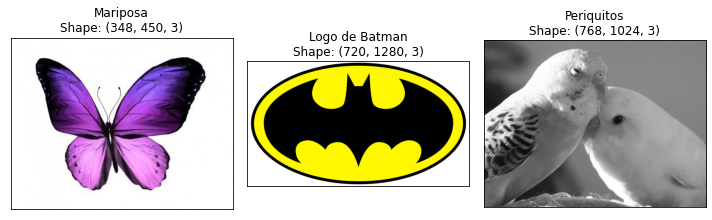

In [139]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(ruta = "Data/butterfly.jpg", title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(ruta = "Data/LogBatman.jpg", title = "Logo de Batman")

plt.subplot(1,3,3)
muestra_imagen(ruta = "Data/periquitos.jpg", title = "Periquitos")

plt.tight_layout()
# plt.savefig("./DiferenciaDeFormas.png",format="png",bbox_inches='tight')
plt.show()

# Pre-procesamiento
Tal cual se puede apreciar de las imágenes anteriores, podemos darnos cuenta que no comparten mismas dimensiones (Alto o ancho), mientras que el número de canales continúa siendo el mismo en cada uno de los 3 casos, es por ello, que procederemos con un pre-procesamiento, dónde inicialmente buscaremos que nuestras imagenes tengan un estándar en cuando a tamaño.

Observamos que la menor dimensión resulta en la mariposa con 348 x 450

In [140]:
butter_resize = resize_image(ruta="Data/butterfly.jpg")
batman_resize = resize_image(ruta="Data/LogBatman.jpg")
periquitos_resize = resize_image(ruta="Data/periquitos.jpg")

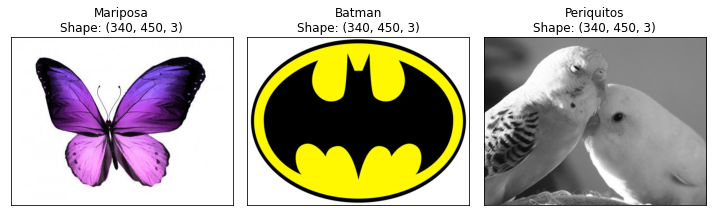

In [142]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(imagen = butter_resize, title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(imagen = batman_resize, title = "Batman")

plt.subplot(1,3,3)
muestra_imagen(imagen = periquitos_resize, title = "Periquitos")

plt.tight_layout()
# plt.savefig("./AjusteDeFormas.png",format="png",bbox_inches='tight')
plt.show()

Una vez que contamos con nuestras imagenes en un estándar, procedemos a la reducción de canales.

3 => 1

In [143]:
butter_resize_gray = cv2.cvtColor(butter_resize, cv2.COLOR_BGR2GRAY)
batman_resize_gray = cv2.cvtColor(batman_resize, cv2.COLOR_BGR2GRAY)
periquitos_resize_gray = cv2.cvtColor(periquitos_resize, cv2.COLOR_BGR2GRAY)

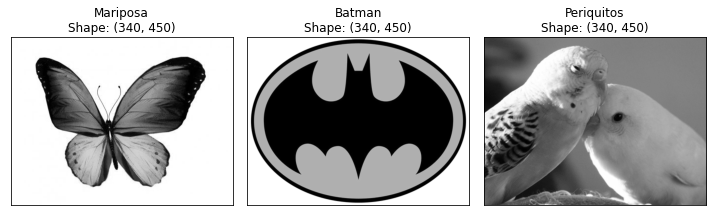

In [144]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(imagen = butter_resize_gray, title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(imagen = batman_resize_gray, title = "Batman")

plt.subplot(1,3,3)
muestra_imagen(imagen = periquitos_resize_gray, title = "Periquitos")

plt.tight_layout()
# plt.savefig("./ReduccionCanales.png",format="png",bbox_inches='tight')
plt.show()

A este punto del proyecto contamos con un estándar en los tamaños, así como un único canal a analizar, es por ello que lo único que falta (no es muy difícil de identificar) es agregar ruido blanco a la imagen.

In [148]:
butter_resize_gray_noise = agrega_ruido(butter_resize_gray)
batman_resize_gray_noise = agrega_ruido(batman_resize_gray)
periquitos_resize_gray_noise = agrega_ruido(periquitos_resize_gray)

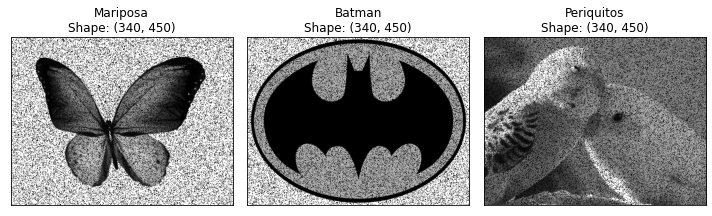

In [149]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(imagen = butter_resize_gray_noise, title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(imagen = batman_resize_gray_noise, title = "Batman")

plt.subplot(1,3,3)
muestra_imagen(imagen = periquitos_resize_gray_noise, title = "Periquitos")

plt.tight_layout()
# plt.savefig("./Ruido_25_per.png",format="png",bbox_inches='tight')
plt.show()

Dado el análisis anterior, trabajaremos ya no sólo con las 3 imágenes, sino con 2 tipos de niveles de ruido
- Al 25%
- Al 5%

Por lo que finalemente generamos nuestros 2 conjuntos de datos

In [151]:
butter_noise_25 = preprocesa(ruta = "Data/butterfly.jpg")
batman_noise_25 = preprocesa(ruta = "Data/LogBatman.jpg")
periquitos_noise_25 = preprocesa(ruta = "Data/periquitos.jpg")

In [152]:
butter_noise_5 = preprocesa(ruta = "Data/butterfly.jpg", porcentaje=5.0)
batman_noise_5 = preprocesa(ruta = "Data/LogBatman.jpg", porcentaje=5.0)
periquitos_noise_5 = preprocesa(ruta = "Data/periquitos.jpg", porcentaje=5.0)

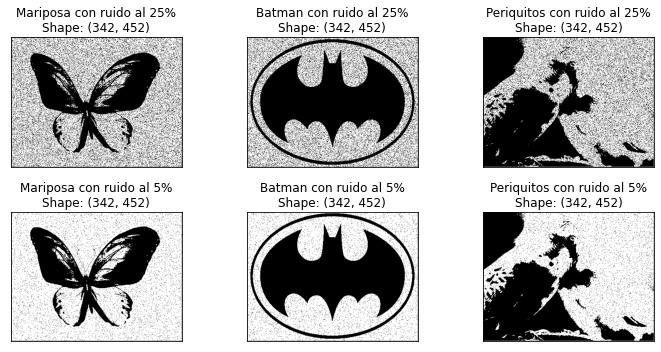

In [154]:
plt.figure(figsize=(10,5))

plt.subplot(2,3,1)
muestra_imagen(imagen = butter_noise_25, title = "Mariposa con ruido al 25%")

plt.subplot(2,3,2)
muestra_imagen(imagen = batman_noise_25, title = "Batman con ruido al 25%")

plt.subplot(2,3,3)
muestra_imagen(imagen = periquitos_noise_25, title = "Periquitos con ruido al 25%")


plt.subplot(2,3,4)
muestra_imagen(imagen = butter_noise_5, title = "Mariposa con ruido al 5%")

plt.subplot(2,3,5)
muestra_imagen(imagen = batman_noise_5, title = "Batman con ruido al 5%")

plt.subplot(2,3,6)
muestra_imagen(imagen = periquitos_noise_5, title = "Periquitos con ruido al 5%")


plt.tight_layout()
# plt.savefig("./Ruido_comparacion.png",format="png", bbox_inches='tight')
plt.show()

# Aplicando Muestreo de Gibbs

In [156]:
butter_noise_25_Gbbs, burn_butt_25, s_butt_25 = get_posterior(butter_noise_25, 100, 100)


Tardó:
435.10905838012695 segundos.
7.25 minutos.



In [157]:
batman_noise_25_Gbbs, burn_patt_25, s_patt_25 = get_posterior(batman_noise_25, 100, 100)


Tardó:
437.26724219322205 segundos.
7.29 minutos.



In [158]:
periquitos_noise_25_Gbbs, burn_per_25, s_per_25 = get_posterior(periquitos_noise_25, 100, 100)


Tardó:
435.19393944740295 segundos.
7.25 minutos.



In [159]:
butter_noise_5_Gbbs, burn_butt_5, s_butt_5 = get_posterior(butter_noise_5, 100, 100)


Tardó:
434.9249210357666 segundos.
7.25 minutos.



In [160]:
batman_noise_5_Gbbs, burn_patt_5, s_patt_5 = get_posterior(batman_noise_5, 100, 100)


Tardó:
437.0145001411438 segundos.
7.28 minutos.



In [161]:
periquitos_noise_5_Gbbs, burn_per_5, s_per_5 = get_posterior(periquitos_noise_5, 100, 100)


Tardó:
438.8507761955261 segundos.
7.31 minutos.



# Resultados

In [162]:
# Juntamos Los valores de quemado en la misma lista 
burn_list = [burn_butt_25, burn_patt_25, burn_per_25, burn_butt_5, burn_patt_5,burn_per_5 ]

# Almacenamos los valores fuera del período de quemado
sample_list = [s_butt_25, s_patt_25, s_per_25, s_butt_5, s_patt_5, s_per_5]

Mostramos las imágenes resultantes

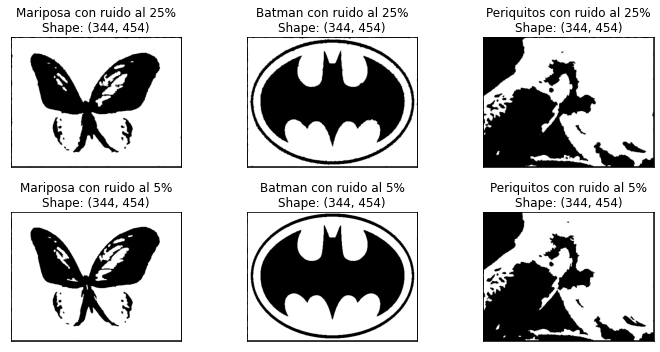

In [166]:
plt.figure(figsize=(10,5))

plt.subplot(2,3,1)
muestra_imagen(imagen = butter_noise_25_Gbbs, title = "Mariposa con ruido al 25%")

plt.subplot(2,3,2)
muestra_imagen(imagen = batman_noise_25_Gbbs, title = "Batman con ruido al 25%")

plt.subplot(2,3,3)
muestra_imagen(imagen = periquitos_noise_25_Gbbs, title = "Periquitos con ruido al 25%")


plt.subplot(2,3,4)
muestra_imagen(imagen = butter_noise_5_Gbbs, title = "Mariposa con ruido al 5%")

plt.subplot(2,3,5)
muestra_imagen(imagen = batman_noise_5_Gbbs, title = "Batman con ruido al 5%")

plt.subplot(2,3,6)
muestra_imagen(imagen = periquitos_noise_5_Gbbs, title = "Periquitos con ruido al 5%")

plt.tight_layout()

# plt.savefig("./Resultados.png", format="png", bbox_inches='tight')
plt.show()

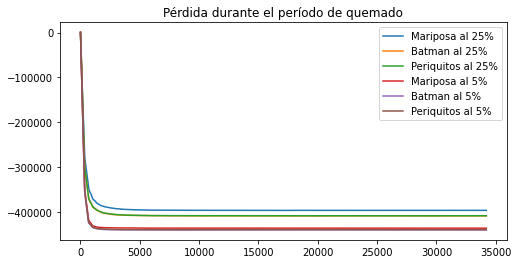

In [173]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(burn_list[0])+1),np.array(burn_list[0])[:,1])
plt.plot(np.arange(1,len(burn_list[0])+1),np.array(burn_list[1])[:,1])
plt.plot(np.arange(1,len(burn_list[0])+1),np.array(burn_list[2])[:,1])
plt.plot(np.arange(1,len(burn_list[0])+1),np.array(burn_list[3])[:,1])
plt.plot(np.arange(1,len(burn_list[0])+1),np.array(burn_list[4])[:,1])
plt.plot(np.arange(1,len(burn_list[0])+1),np.array(burn_list[5])[:,1])

plt.legend(["Mariposa al 25%","Batman al 25%", "Periquitos al 25%","Mariposa al 5%","Batman al 5%", "Periquitos al 5%"])
plt.title("Pérdida durante el período de quemado")
# plt.savefig("./Periodo_quemado.png", format="png", bbox_inches='tight')

plt.show()

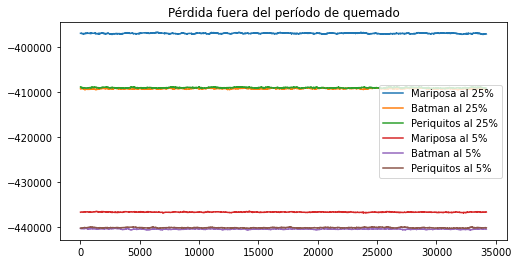

In [175]:

plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[0])[:,1])
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[1])[:,1])
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[2])[:,1])
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[3])[:,1])
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[4])[:,1])
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[5])[:,1])

plt.legend(["Mariposa al 25%","Batman al 25%", "Periquitos al 25%","Mariposa al 5%","Batman al 5%", "Periquitos al 5%"])
plt.title("Pérdida fuera del período de quemado")
# plt.savefig("./out_quemado.png", format="png", bbox_inches='tight')

plt.show()

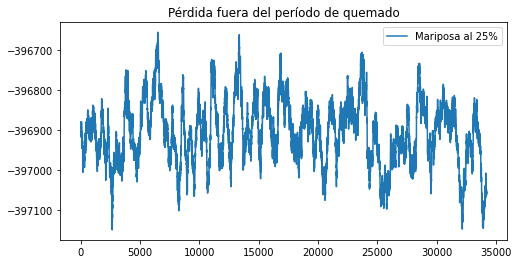

In [178]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[0])[:,1])
plt.legend(["Mariposa al 25%"])
plt.title("Pérdida fuera del período de quemado")
# plt.savefig("./Periodo_de_quemado_Mariposa25.png", format="png", bbox_inches='tight')

plt.show()

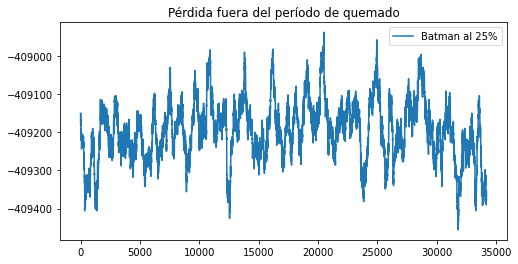

In [179]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[1])[:,1])
plt.legend(["Batman al 25%"])
plt.title("Pérdida fuera del período de quemado")
# plt.savefig("./Periodo_de_quemado_Batman25.png", format="png", bbox_inches='tight')

plt.show()

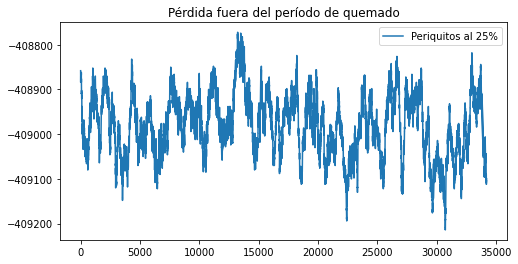

In [180]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[2])[:,1])
plt.legend(["Periquitos al 25%"])
plt.title("Pérdida fuera del período de quemado")
# plt.savefig("./Periodo_de_quemado_Periquitos25.png", format="png", bbox_inches='tight')

plt.show()

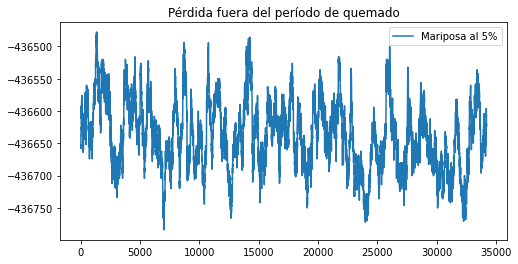

In [185]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[3])[:,1])
plt.legend(["Mariposa al 5%"])
plt.title("Pérdida fuera del período de quemado")
# plt.savefig("./Out_de_quemado_Mariposa5.png", format="png", bbox_inches='tight')

plt.show()

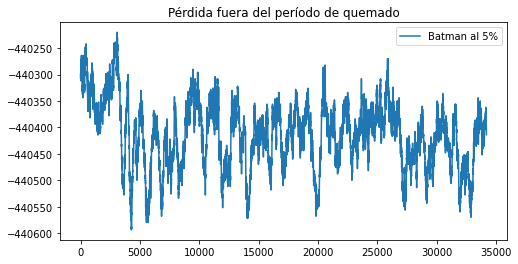

In [186]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[4])[:,1])
plt.legend(["Batman al 5%"])
plt.title("Pérdida fuera del período de quemado")
# plt.savefig("./Out_de_quemado_Batman5.png", format="png", bbox_inches='tight')

plt.show()

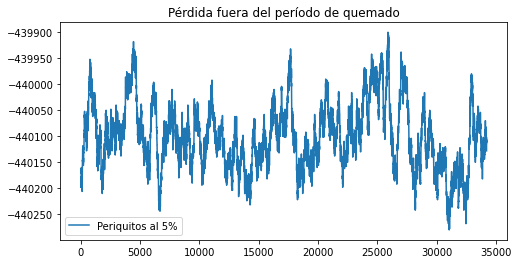

In [187]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,len(sample_list[0])+1),np.array(sample_list[5])[:,1])
plt.legend(["Periquitos al 5%"])
plt.title("Pérdida fuera del período de quemado")
# plt.savefig("./Out_de_quemado_Periquitos5.png", format="png", bbox_inches='tight')

plt.show()